In [98]:
import pandas as pd
import numpy as np
import config
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from models import data_preparation
import re
import emoji
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import torch
from transformers import RobertaForSequenceClassification, BertForSequenceClassification
from transformers import RobertaTokenizer, BertTokenizer
from models.training_pytorch import objective, train_model_with_hyperparams
from models.training_HF import objective_HF
from models.model_config import model_configs
import optuna
import wandb
import argparse
from dotenv import load_dotenv
import os

In [99]:
data_path = config.DATA_DIR 
TWEETS_DATA = pd.read_csv(data_path / "Corona_NLP_train.csv",encoding='ISO-8859-1') 
TEST_DATA = pd.read_csv(data_path / "Corona_NLP_test.csv",encoding='ISO-8859-1')
CSV_PATH = config.DATA_DIR/"processed"


# EDA 
We start exploring the data

In [100]:
pd.set_option('display.max_colwidth', None)
print(TWEETS_DATA.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                                                                                                                                                                                                                                                                                                        OriginalTweet  \
0                                                                                                                                                                                                                     @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8   
1                                        

1. There are several id columns: Username and ScreenName
2. The date, location of the tweet are categorical
3. sentiment is categorical ordinal    
    
  **let's try to plot and understand the data better**

In [101]:
print(f"The number of unique ScreenNames: {np.unique(len(TWEETS_DATA['ScreenName']))}")
print(f"The number of unique UserNames: {np.unique(len(TWEETS_DATA['UserName']))}")
print("The length of the data: ", len(TWEETS_DATA))

The number of unique ScreenNames: [41157]
The number of unique UserNames: [41157]
The length of the data:  41157


First of all let's plot the Sentiment

/tmp/ipykernel_323135/2687516525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=TWEETS_DATA, x='Sentiment', order=custom_order, palette='deep')


<Axes: xlabel='Sentiment', ylabel='count'>

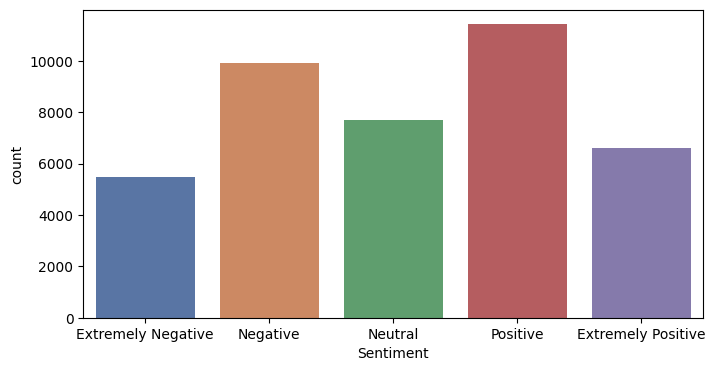

In [102]:
custom_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
plt.figure(figsize=(8, 4))
sns.countplot(data=TWEETS_DATA, x='Sentiment', order=custom_order, palette='deep')

In [103]:
print(TWEETS_DATA["TweetAt"].value_counts())

TweetAt
20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: count, dtype: int64


We Can see that the data was taken in march and april,  when covid was at its initial peak, 
let's see if the month can tell us something.  
Maybe one month was more negative than the other

month
3    25499
4    15658
Name: count, dtype: int64


/tmp/ipykernel_323135/3598013752.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  TWEETS_DATA["month"] = pd.to_datetime(TWEETS_DATA["TweetAt"]).dt.month


Text(0.5, 1.0, 'Sentiment Distribution by Month')

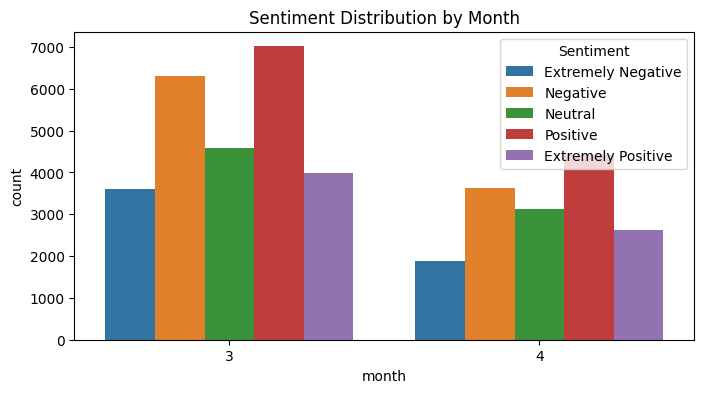

In [104]:
TWEETS_DATA["month"] = pd.to_datetime(TWEETS_DATA["TweetAt"]).dt.month
print(TWEETS_DATA["month"].value_counts())
## plot sentiment by month
plt.figure(figsize=(8,4))
sns.countplot(data=TWEETS_DATA, x='month', hue='Sentiment', hue_order=custom_order)
plt.title('Sentiment Distribution by Month')

It looks like it distributes the same, counting that march had twice has much tweets

In [105]:
print(TWEETS_DATA["Location"].value_counts())

Location
London                           540
United States                    528
London, England                  520
New York, NY                     395
Washington, DC                   373
                                ... 
London / Warwickshire              1
Round Earth                        1
Uganda Kampala                     1
Views don't reflect employers      1
San Mateo, California, USA         1
Name: count, Length: 12220, dtype: int64


It seems that are too many different locations to try to put them together, we will look into it later $$$**##

**Now let's plot the tweets data, let's see what's poping as obvious**

<Axes: xlabel='text_len', ylabel='Count'>

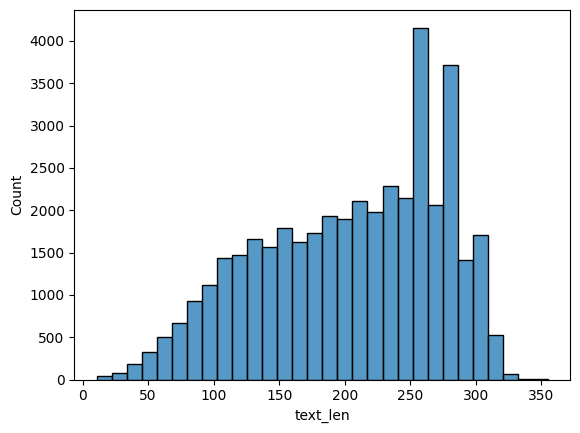

In [106]:
TWEETS_DATA['text_len'] = TWEETS_DATA['OriginalTweet'].str.len()
sns.histplot(TWEETS_DATA['text_len'], bins=30)

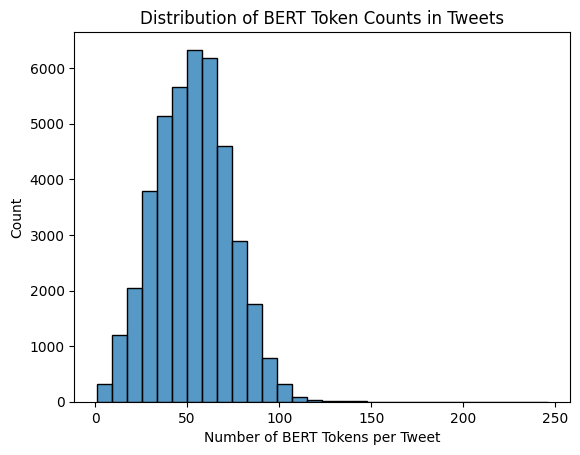

In [107]:

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Compute number of tokens per tweet
TWEETS_DATA['num_bert_tokens'] = TWEETS_DATA['OriginalTweet'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histogram
sns.histplot(TWEETS_DATA['num_bert_tokens'], bins=30)
plt.xlabel("Number of BERT Tokens per Tweet")
plt.ylabel("Count")
plt.title("Distribution of BERT Token Counts in Tweets")
plt.show()


We know the tweeter (former X) had a 280 charecters limit, over it are paid users.  
let's see if it can gain us some knowledge

Ratio of positive to negative tweets in paid users: 1.302897278314311
The ratio of positive to negative tweets in free users: 1.1321485532011848


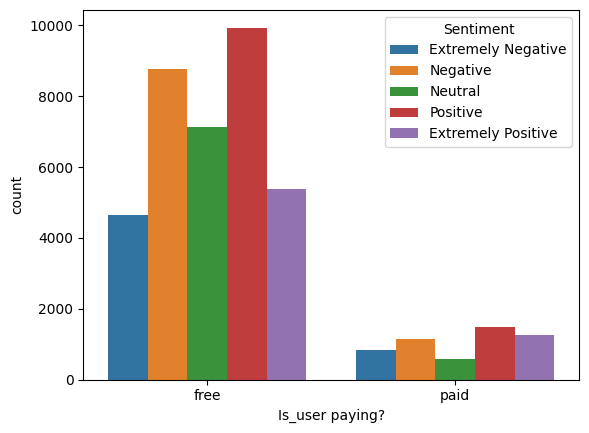

In [108]:
TWEETS_DATA["paid_user"] = TWEETS_DATA["OriginalTweet"].apply(lambda x: "paid" if len(x) > 280 else "free")
sns.countplot(data=TWEETS_DATA, x='paid_user', hue='Sentiment', hue_order=custom_order)
plt.xlabel("Is_user paying?")
paid_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'paid']
free_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'free']

positive = paid_users[paid_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = paid_users[paid_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"Ratio of positive to negative tweets in paid users: {len(positive) / len(negative)}")

positive = free_users[free_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = free_users[free_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"The ratio of positive to negative tweets in free users: {len(positive) / len(negative)}")


The ratios of negative vs positive are relatively the same for paid and free users, so status isn't a good indicator of sentiment.

## Wordclouds
Wordclouds are a great way to visualize the most common words in the tweets.

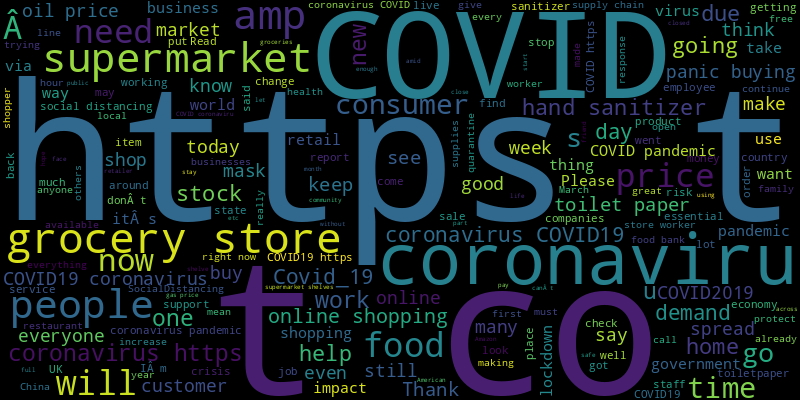

In [109]:
text = " ".join(TWEETS_DATA['OriginalTweet'])
WordCloud(width=800, height=400).generate(text).to_image()

https, amp, t, u, Â, itÂ, donÂ, IÂ  Are HTML tokens that we need to take out of the dataset! 

In [110]:
#INSTEAD OF THIS i SUGGEST DOING THIS (because currently some symbols like \r\r\n\r\r\n are still present):


def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\bamp\b', '', text)                 # Remove "amp"
    text = re.sub(r'\r|\n', ' ', text)                  # Replace \r and \n with space
    text = re.sub(r'\s+', ' ', text).strip()                    # Remove mentions
    return text

#apply:
TWEETS_DATA["tweets"] = TWEETS_DATA["OriginalTweet"].apply(clean_tweet)
TEST_DATA["tweets"] = TEST_DATA["OriginalTweet"].apply(clean_tweet)

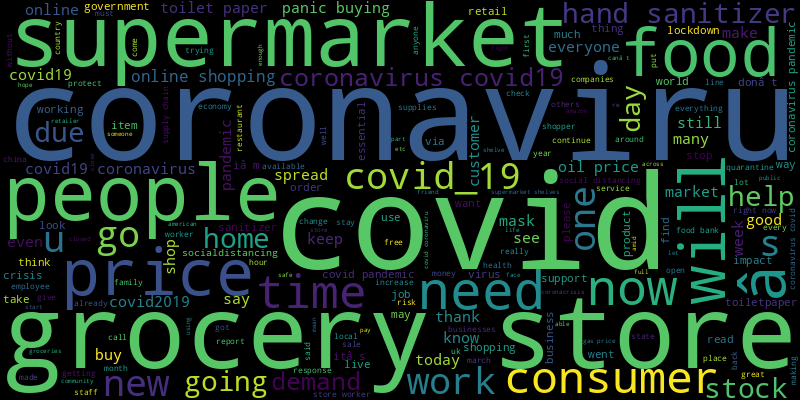

In [111]:
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

In order to take care of weird signs like: 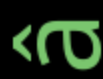  
We tried different encodings (latin and ISO-8859-1)  
We going to take it out manually

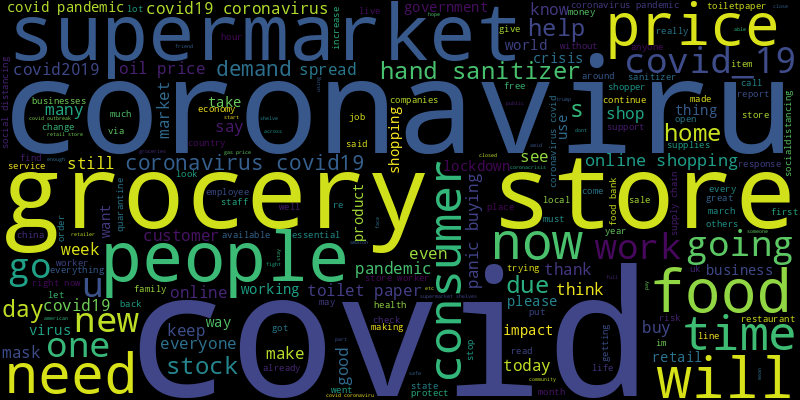

In [112]:
TWEETS_DATA["tweets"] = TWEETS_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)

TEST_DATA["tweets"] = TEST_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

Now we will explore more wordclouds - per sentiment

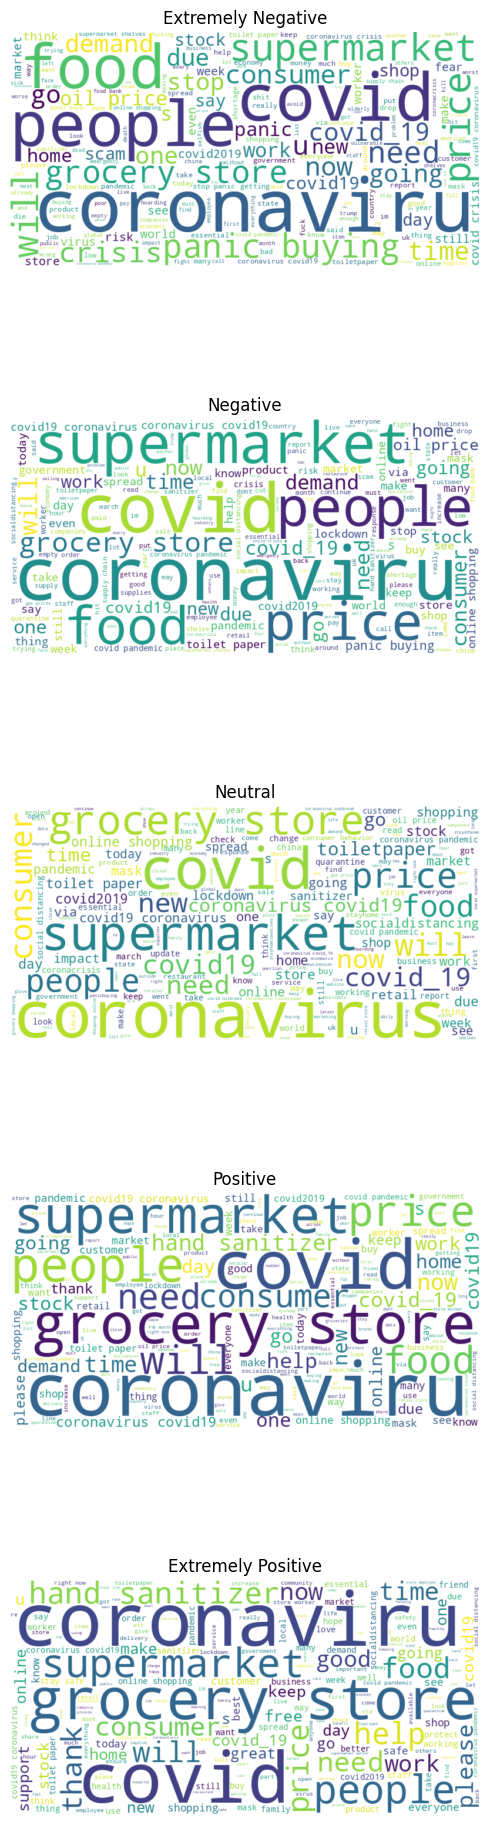

In [113]:
sentiments = custom_order
num_clouds = len(sentiments)

fig, axes = plt.subplots(5, 1, figsize=(5, 20))


# If only one sentiment, axes isn't a list — make it one
if num_clouds == 1:
    axes = [axes]

# Loop through each sentiment and create a word cloud
for ax, sentiment in zip(axes, sentiments):
    subset = TWEETS_DATA[TWEETS_DATA['Sentiment'] == sentiment]
    text = " ".join(subset['tweets'])
    
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(sentiment)
    ax.axis('off')

plt.tight_layout()
plt.show()


Looks like all wordclouds contain similar words, perhaps dipper analysis should be done while extracting covid related key words, to explore better sentiment related words (becuase obsviously positive and negative tweets discussed covid)

**As we all know X (former tweeter) has # and @ in the tweets, let's try to gain some insight from it**

/tmp/ipykernel_323135/3875072588.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_hashtags, x='hashtags', order=top_hashtags, palette='viridis', ax=axes[0])
/tmp/ipykernel_323135/3875072588.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_ats, x='ats', order=top_ats, palette='coolwarm', ax=axes[1])


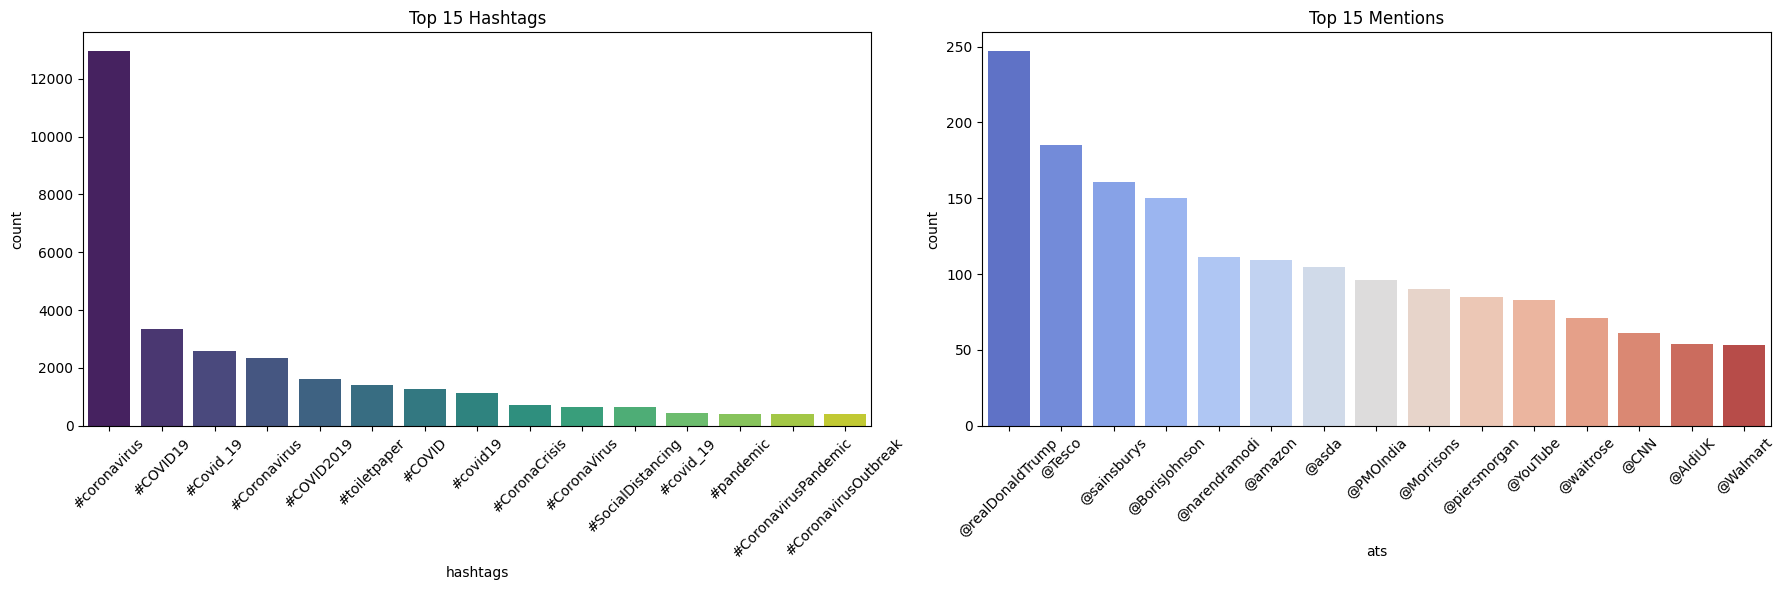

In [114]:

# Extract @ and #
TWEETS_DATA['hashtags'] = TWEETS_DATA['OriginalTweet'].str.findall(r'#\w+')
TWEETS_DATA['ats'] = TWEETS_DATA['OriginalTweet'].str.findall(r'@\w+')

# Explode and clean
hashtags_df = TWEETS_DATA.explode('hashtags')
ats_df = TWEETS_DATA.explode('ats')

hashtags_df = hashtags_df[hashtags_df['hashtags'].notna()]
ats_df = ats_df[ats_df['ats'].notna()]

# Top N
top_n = 15
top_hashtags = hashtags_df['hashtags'].value_counts().nlargest(top_n).index
top_ats = ats_df['ats'].value_counts().nlargest(top_n).index

# Filtered
filtered_hashtags = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]
filtered_ats = ats_df[ats_df['ats'].isin(top_ats)]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

sns.countplot(data=filtered_hashtags, x='hashtags', order=top_hashtags, palette='viridis', ax=axes[0])
axes[0].set_title(f"Top {top_n} Hashtags")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=filtered_ats, x='ats', order=top_ats, palette='coolwarm', ax=axes[1])
axes[1].set_title(f"Top {top_n} Mentions")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


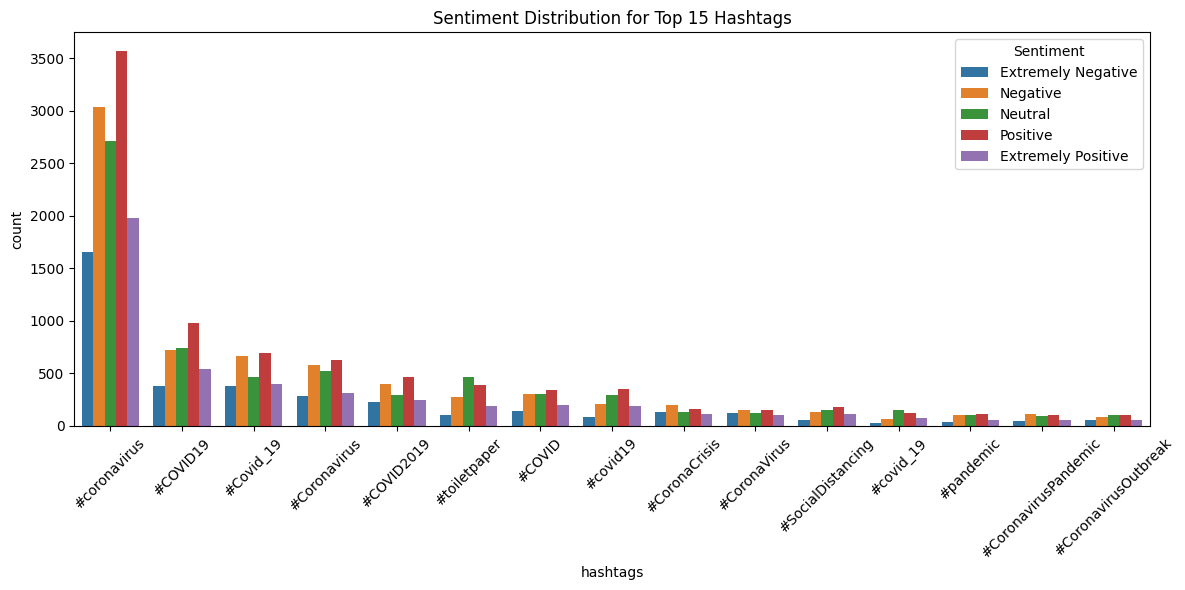

In [115]:
# Filter again to include Sentiment
sentiment_hashtags_df = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_hashtags_df, x='hashtags', hue='Sentiment', order=top_hashtags, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 Hashtags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that hashtags are pretty balanced across sentiments, and also that many are variations on same words, like covid, covid19, coronavirus, corona, etc. So hashtags for now don't seem useful.

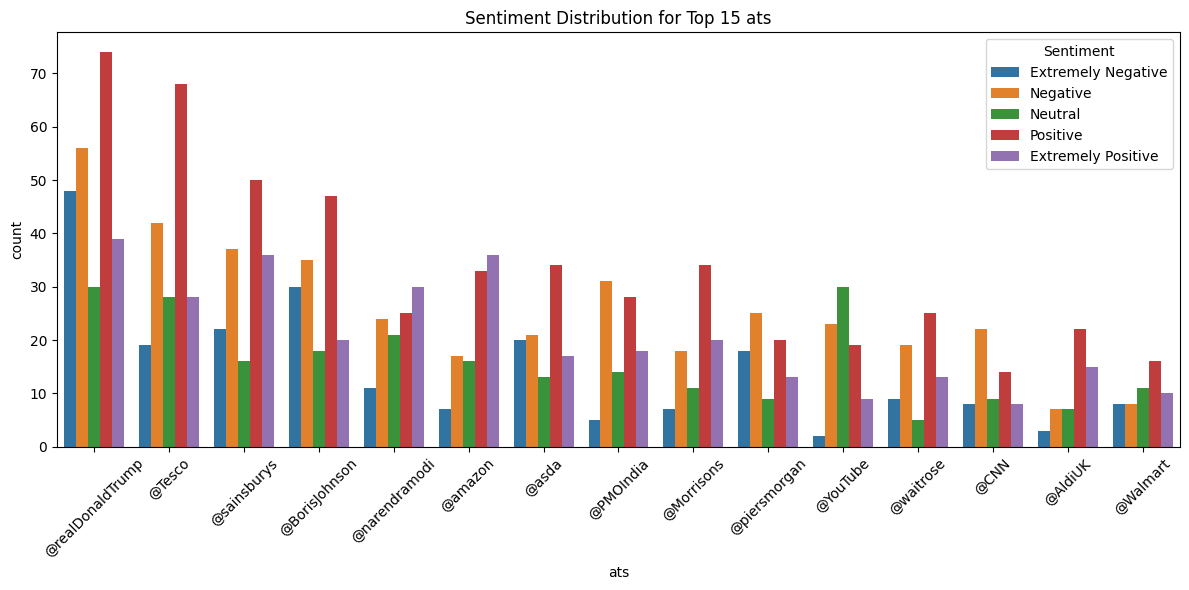

In [116]:
# Filter again to include Sentiment
sentiment_ats_df = ats_df[ats_df['ats'].isin(top_ats)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_ats_df, x='ats', hue='Sentiment', order=top_ats, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 ats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Preprocessing
After the exploring and some preprocessing we already made (removing special characters, html...), we shall prepare our data to the models of choice

In [117]:
#make labels numerical using a dict:
label_map = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}
# Convert labels to numerical values
TWEETS_DATA['Sentiment'] = TWEETS_DATA['Sentiment'].map(label_map)
TEST_DATA['Sentiment'] = TEST_DATA['Sentiment'].map(label_map)

In [118]:
TWEETS_DATA
#I can see that there are still some symbols like: \r\r\n\r\r\n - we 

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text_len,num_bert_tokens,paid_user,tweets,hashtags,ats
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,2,3,111,58,free,@menyrbie @phil_gahan @chrisitv and and,[],"[@MeNyrbie, @Phil_Gahan, @Chrisitv]"
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,3,3,237,40,free,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order,[],[]
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",3,3,131,36,free,"coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak",[],[]
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",3,3,306,88,paid,"my food stock is not the only one which is empty... please, don't panic, there will be enough food for everyone if you do not take more than you need. stay calm, stay safe. #covid19france #covid_19 #covid19 #coronavirus #confinement #confinementotal #confinementgeneral","[#COVID19france, #COVID_19, #COVID19, #coronavirus, #confinement, #Confinementotal, #ConfinementGeneral]",[]
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0,3,310,88,paid,"me, ready to go at supermarket during the #covid19 outbreak. not because i'm paranoid, but because my food stock is litteraly empty. the #coronavirus is a serious thing, but please, don't panic. it causes shortage... #coronavirusfrance #restezchezvous #stayathome #confinement","[#COVID19, #coronavirus, #CoronavirusFrance, #restezchezvous, #StayAtHome, #confinement]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,2,4,102,33,free,airline pilots offering to stock supermarket shelves in #nz lockdown #covid-19,"[#NZ, #COVID]",[]
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,0,4,138,29,free,response to complaint not provided citing covid-19 related delays. yet prompt in rejecting policy before consumer tat is over. way to go ?,[],[]
41154,44953,89905,NaN,14-04-2020,"You know itÂs getting tough when @KameronWilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!",3,4,136,35,free,"you know its getting tough when @kameronwilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!","[#coronavirus, #toiletpaper]","[@KameronWilds, @kroger]"
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer is starting to turn me on?\r\r\n\r\r\n#coronavirus #COVID19 #coronavirus,2,4,111,28,free,is it wrong that the smell of hand sanitizer is starting to turn me on? #coronavirus #covid19 #coronavirus

In [119]:
#prepare data for models: leave only text and labels
train_df = TWEETS_DATA[['tweets', 'Sentiment']]
test_df = TEST_DATA[['tweets', 'Sentiment']]

In [120]:
# Split into train (70%) and temp (30%)
train_df, eval_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['Sentiment'])

#Save 
train_df.to_csv(CSV_PATH / 'train_data.csv', index=False)
test_df.to_csv(CSV_PATH / 'test_data.csv', index=False)
eval_df.to_csv(CSV_PATH / 'eval_data.csv', index=False)

## Part B: Further analysis for second training of the models

In [121]:
def evaluate_model_confusion_matrix(model, val_loader, device, class_names=None, normalize=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix - Val Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Classification report
    if class_names:
        print(classification_report(all_labels, all_preds, target_names=class_names))
    else:

        print(classification_report(all_labels, all_preds))

In [122]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_key = "bertweet"
config = model_configs[model_key]
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
model_name = config["model_name"]
model_class = config["model_class"]
max_length = config["max_length"]
tokenizer_class = config["tokenizer_class"]
base_attr = config["base_attr"]
project_name="for_confusion"
lr = 0.000027603
weight_decay = 0.000057487
patience = 10 
batch_size = 64
num_layers = 2

train_dataset,val_dataset, test_dataset = data_preparation.prepare_dataset(tokenizer,max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = model_class.from_pretrained(model_name, num_labels=5)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.roberta.encoder.layer[-num_layers:].parameters():
    param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
best_val_acc = train_model_with_hyperparams(model, train_loader, val_loader,optimizer, criterion, epochs=20, patience=patience,trial=1,device=device, project_name="for_confusion")



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/hdd/itai/nlp_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


KeyboardInterrupt: 

In [123]:
## Load model from file
model_path = f"/mnt/hdd/itai/corona_virus_NLP/results/for_confusion/best_model_trial_1.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

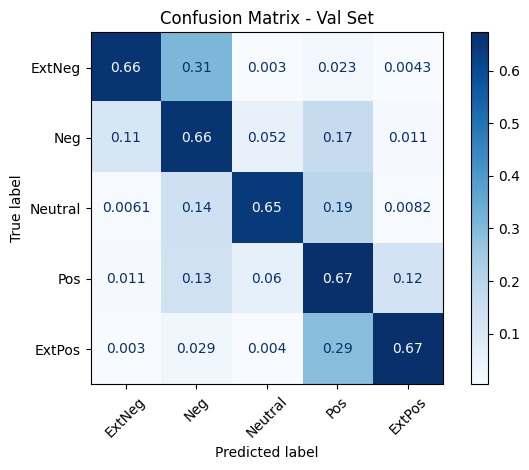

              precision    recall  f1-score   support

      ExtNeg       0.74      0.66      0.70      1645
         Neg       0.59      0.66      0.62      2975
     Neutral       0.80      0.65      0.72      2314
         Pos       0.60      0.67      0.63      3427
      ExtPos       0.73      0.67      0.70      1987

    accuracy                           0.66     12348
   macro avg       0.69      0.66      0.67     12348
weighted avg       0.67      0.66      0.67     12348



In [124]:
evaluate_model_confusion_matrix(
    model,
    val_loader,
    device,
    class_names=["ExtNeg", "Neg", "Neutral", "Pos", "ExtPos"],
    normalize=True
)

#### From the Confusion matrix we can see that the model tens to miss Extremly positive and Extremly Negatives.  
Let's take a look at them

EXTREMLY NEGATIVE

In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 0]['tweets'].head(3))


4     me, ready to go at supermarket during the #covid19 outbreak. not because i'm paranoid, but because my food stock is litteraly empty. the #coronavirus is a serious thing, but please, don't panic. it causes shortage... #coronavirusfrance #restezchezvous #stayathome #confinement
20                                                with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty of being irosponcible with life on a global scale
27                           this morning i tested positive for covid 19. i feel ok, i have no symptoms so far but have been isolated since i found out about my possible exposure to the virus. stay home people and be pragmatic. i will keep you updated on how im doing ???? no panic.
Name: tweets, dtype: object


In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 1]['tweets'].head(3))

9     for corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. also we should prefer online shopping from our home. it's time to fight against covid 19?. #govindia #indiafightscorona
24                                              what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? it cannot be left to checkout staff to police the actions of the selfish and profiteer
26                                                                                             in preparation for higher demand and a potential food shortage, the hunger coalition purchased 10 percent more food and implemented new protocols due to the covid-19 coronavirus.
Name: tweets, dtype: object


In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 4]['tweets'].head(3))

11                                    due to the covid-19 situation, we have increased demand for all food products. the wait time may be longer for all online orders, particularly beef share and freezer packs. we thank you for your patience during this time.
12    #horningsea is a caring community. lets all look after the less capable in our village and ensure they stay healthy. bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has.
18       amazon glitch stymies whole foods, fresh grocery deliveries as covid-19 has spread, weve seen a significant increase in people shopping online for groceries, a spokeswoman said in a statement. today this resulted in a systems impact affecting our ...
Name: tweets, dtype: object


In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 3]['tweets'].head(3))

1                                    advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                      coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak
3    my food stock is not the only one which is empty... please, don't panic, there will be enough food for everyone if you do not take more than you need. stay calm, stay safe. #covid19france #covid_19 #covid19 #coronavirus #confinement #confinementotal #confinementgeneral
Name: tweets, dtype: object
